# CSE 252A Computer Vision I Fall 2019 - Homework 5

## Instructor: Ben Ochoa
### Assignment Published On: Thursday, November 21, 2019
### Due On: Saturday, December 7, 2019 11:59 pm

## Instructions
* Review the academic integrity and collaboration policies on the course website.
  * This assignment must be completed individually.
* All solutions must be written in this notebook.
  * Programming aspects of the assignment must be completed using Python in this notebook.
* If you want to modify the skeleton code, you may do so. It has only been provided as a framework for your solution.
* You may use Python packages (such as NumPy and SciPy) for basic linear algebra, but you may not use packages that directly solve the problem.
  * If you are unsure about using a specific package or function, then ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF. You must also submit this notebook as `.ipynb` file.
  * Submit both files (`.pdf` and `.ipynb`) on Gradescope.
  * **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late policy: assignments submitted late will receive a 15% grade reduction for each 12 hours late (i.e., 30% per day). Assignments will not be accepted 72 hours after the due date. If you require an extension (for personal reasons only) to a due date, you must request one as far in advance as possible. Extensions requested close to or after the due date will only be granted for clear emergencies or clearly unforeseeable circumstances.**

## Problem 1: Optical Flow [14 pts]

In this problem, the multi-resolution Lucas-Kanade algorithm for estimating optical flow will be implemented, and the data needed for this problem can be found in the folder 'optical_flow_images'.

An example optical flow output is shown below - this is not a solution, just an example output.

![title](optical_flow_images/sample_optical_flow_output.png)

### Part 1: Multi-resolution Lucas-Kanade implementation [6 pts]

Implement the Lucas-Kanade method for estimating optical flow. The function 'LucasKanadeMultiScale' needs to be completed. You can implement 'upsample_flow' and 'OpticalFlowRefine' as 2 building blocks in order to complete this.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# from tqdm import tqdm_notebook

def grayscale(img):
    '''
    Converts RGB image to Grayscale
    '''
    gray=np.zeros((img.shape[0],img.shape[1]))
    gray=img[:,:,0]*0.2989+img[:,:,1]*0.5870+img[:,:,2]*0.1140
    return gray

def plot_optical_flow(img,U,V,titleStr):
    '''
    Plots optical flow given U,V and one of the images
    '''
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t=10 
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.quiver(cols,rows,U1,V1)
    plt.title(titleStr)
    plt.show()
    

images=[]
for i in range(1,5):
    images.append(plt.imread('optical_flow_images/im'+str(i)+'.png')[:,:288,:])
# each image after converting to gray scale is of size -> 400x288

In [80]:
# you can use interpolate from scipy
# You can implement 'upsample_flow' and 'OpticalFlowRefine' 
# as 2 building blocks in order to complete this.
from scipy.signal import convolve
from scipy import interpolate
def gradient(im1,im2):
    """ ==========
    Compute gradient of the image
    ========== """
    x_dir = np.array([-1/2, 0, 1/2]).reshape((1,3))
    y_dir = np.array([-1/2, 0, 1/2]).reshape((3,1))
    dIx = convolve(im1,x_dir,mode="same")
    dIy = convolve(im1,y_dir,mode="same")
    dIt = im2-im1
    return dIx,-dIy,dIt
    
def upsample_flow(u_prev, v_prev):
    ''' You may implement this method to upsample optical flow from
    previous level
    u_prev, v_prev -> optical flow from prev level
    u, v -> upsampled optical flow to the current level
    '''
    f_u = interpolate.interp2d(np.arange(u_prev.shape[1]),np.arange(u_prev.shape[0]),u_prev)
    f_v = interpolate.interp2d(np.arange(v_prev.shape[1]),np.arange(v_prev.shape[0]),v_prev)
    
    u = f_u(np.linspace(0,u_prev.shape[1],u_prev.shape[1]*2),np.linspace(0,u_prev.shape[0],u_prev.shape[0]*2))
    v = f_v(np.linspace(0,v_prev.shape[1],v_prev.shape[1]*2),np.linspace(0,v_prev.shape[0],v_prev.shape[0]*2))
    return u, v

def downsample(img):
    kernel = np.array([[1,4,6,4,1],
                     [4,16,24,16,4],
                     [6,24,36,24,6],
                     [4,16,24,16,4],
                     [1,4,6,4,1]])/256
    downsample_img = convolve(img,kernel,mode='same')
    return downsample_img[::2,::2]

def pyramid(img,n):
    pyramids = [img]
    for _ in range(n-1):
        img = downsample(img)
        pyramids.append(img)
    return pyramids

def OpticalFlowRefine(im1,im2,window, u_prev=None, v_prev=None):
    '''
    Inputs: the two images at current level and window size
    u_prev, v_prev - previous levels optical flow
    Return u,v - optical flow at current level
    '''
    # upsample flow from previous level
    assert im1.shape==u_prev.shape
    u = np.zeros(im1.shape)
    v = np.zeros(im1.shape)
    row,col = im1.shape
    w = window//2
    dIx,dIy,_ = gradient(im1,im2)
    for i in range(w,row-w):
        for j in range(w,col-w):            
            row_i = int(max(0,min(i-int(np.round(v_prev[i,j])),row-w-1))) 
            col_j = int(max(0,min(j-int(np.round(u_prev[i,j])),col-w-1))) 
            Ix = dIx[i-w:i+w+1,j-w:j+w+1].flatten()
            Iy = dIy[i-w:i+w+1,j-w:j+w+1].flatten()
            It = (im1[i-w:i+w+1,j-w:j+w+1]-im2[row_i-w:row_i+w+1,col_j-w:col_j+w+1]).flatten()
            A = np.vstack((Ix, Iy)).T
            M = A.T@A
            b = A.T@-It.reshape(-1,1)
            U = np.linalg.solve(M,b)
            u[i,j] = U[0]
            v[i,j] = U[1]
    return u, v

In [81]:
def LucasKanadeMultiScale(im1,im2,window, numLevels=2):
    '''
    Implement the multi-resolution Lucas kanade algorithm
    Inputs: the two images, window size and number of levels
    if numLevels = 1, then compute optical flow at only the given image level.
    Returns: u, v - the optical flow
    '''
    # call OpticalFlowRefine iteratively
    i = numLevels
    
    pyramids_im1 = pyramid(im1,numLevels)
    pyramids_im2 = pyramid(im2,numLevels)
    u_prev = None
    v_prev = None
    u_star,v_star = np.zeros(pyramids_im1[numLevels-1].shape),np.zeros(pyramids_im1[numLevels-1].shape)
    
    while i > 0:
        if u_prev is not None:
            u_star,v_star = upsample_flow(u_prev,v_prev)
            u_star,v_star = u_star*2,v_star*2
        u_prime,v_prime = OpticalFlowRefine(pyramids_im1[i-1],pyramids_im2[i-1],window,u_star,v_star)
        u_prev,v_prev = u_star+u_prime,v_star+v_prime
        i -= 1
    return u_prev, v_prev

### Part 2: Number of levels [2 pts]

Plot optical flow for the pair of images im1 and im2 for different number of levels mentioned below. Comment on the results and justify.<br>
(i) window size = 13, numLevels = 1<br>
(ii) window size = 13, numLevels = 3<br>
(iii) window size = 13, numLevels = 5<br>
So, you are expected to provide 3 outputs here<br>

Note: if numLevels = 1, then it means the optical flow is only computed at the image resolution i.e. no downsampling

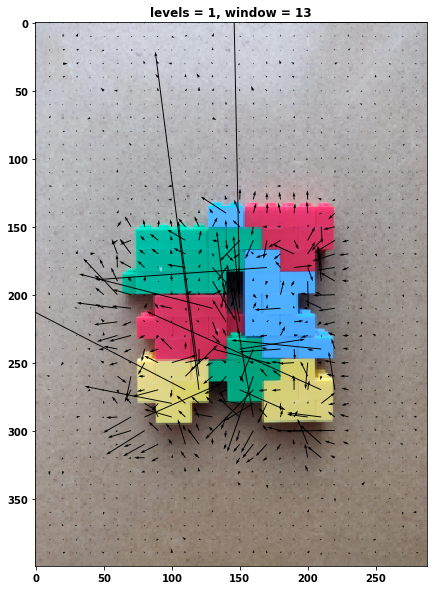

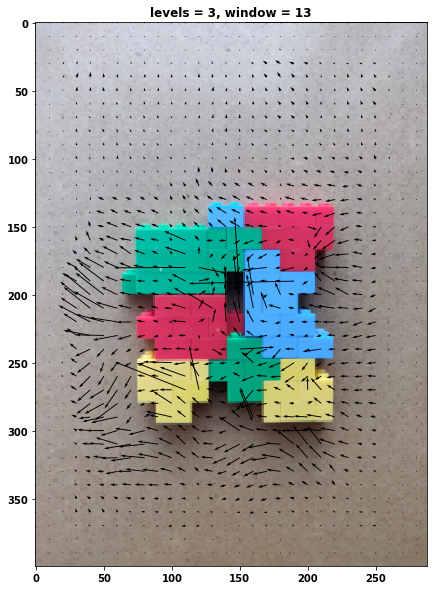

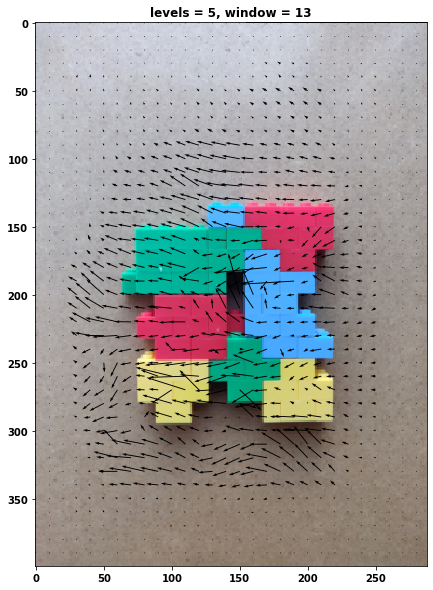

In [82]:
# Example code to generate output
window=13
numLevels=1
U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),window,numLevels)
plot_optical_flow(images[0],U,V, 'levels = ' + str(numLevels) + ', window = '+str(window))

numLevels=3
# Plot
U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),window,numLevels)
plot_optical_flow(images[0],U,V, 'levels = ' + str(numLevels) + ', window = '+str(window))

numLevels=5
# Plot
U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),window,numLevels)
plot_optical_flow(images[0],U,V, 'levels = ' + str(numLevels) + ', window = '+str(window))

#### Your Comments on the results of Part 2:

With number of level goes up, we have finer result. Optical flow becomes more resonable and accurate.

### Part 3: Window size [3 pts]

Plot optical flow for the pair of images im1 and im2 for at least 3 different window sizes which leads to observable difference in the results. Comment on the effect of window size on results and justify. For this part fix the number of levels to be 3.

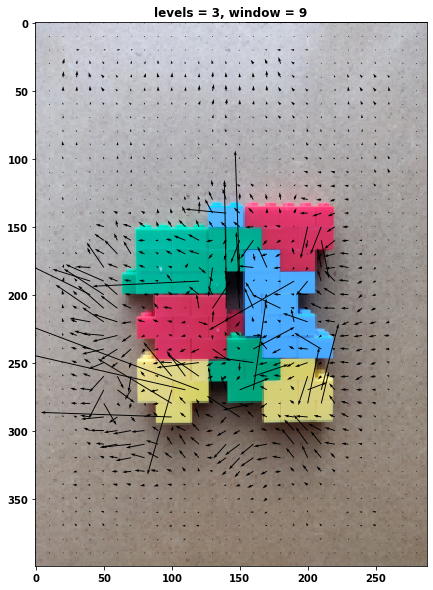

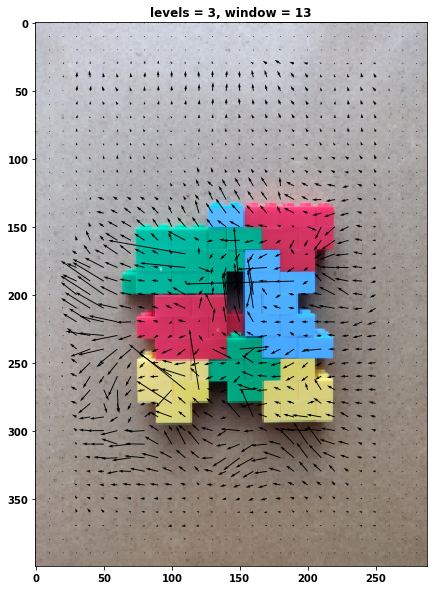

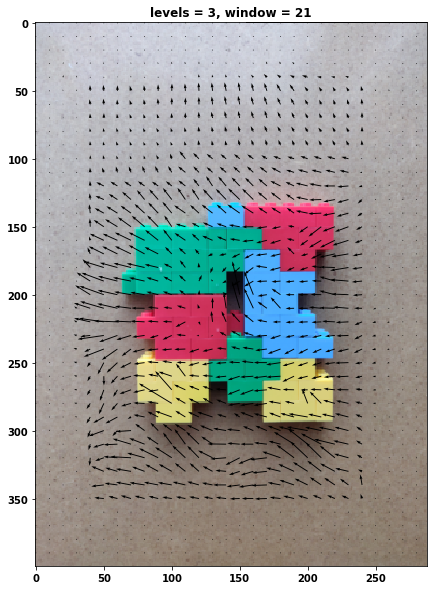

In [5]:
# Example code, change as required
numLevels=3

w1, w2, w3 = 9, 13, 21
for window in [w1, w2, w3]:
    U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                              window,numLevels)
    plot_optical_flow(images[0],U,V, \
                      'levels = ' + str(numLevels) + ', window = '+str(window))

#### Your Comments on the results of Part 3:

If the number of level is fixed and window size is increased, we also get finer results. Thus, with larger window size, optical flow is more reasonable and accurate.

### Part 4: All pairs [3 pts]

Find optical flow for the pairs (im1,im2), (im1,im3), (im1,im4) using one good window size and number of levels. Does the optical flow result seem consistent with visual inspection? Comment on the type of motion indicated by results and visual inspection and explain why they might be consistent or inconsistent.

In [87]:
# Your code here
# use one fixed window and numLevels for all pairs
def plot_pair(a,b):
    window = 21
    numLevels = 5
    U,V = LucasKanadeMultiScale(grayscale(images[a-1]),grayscale(images[b-1]),window,numLevels)
    print('Pair of im{} and im{}:'.format(a,b))
    plot_optical_flow(images[a-1],U,V, 'levels = ' + str(numLevels) + ', window = '+str(window))

Pair of im1 and im2:


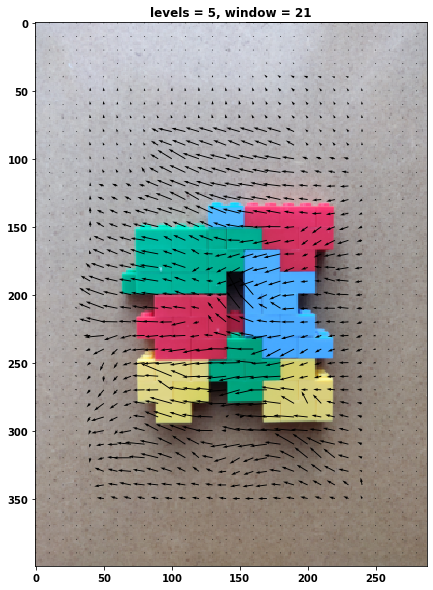

Pair of im1 and im3:


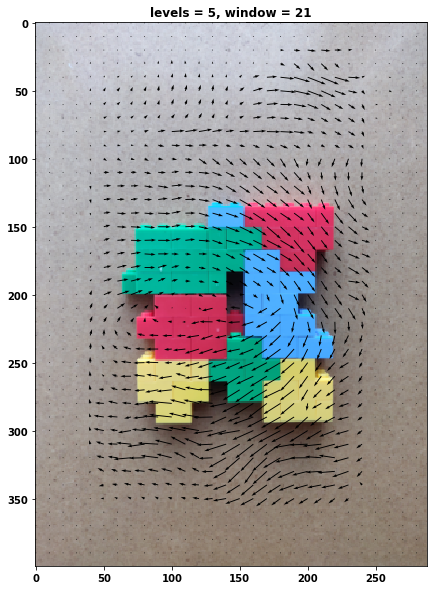

Pair of im1 and im4:


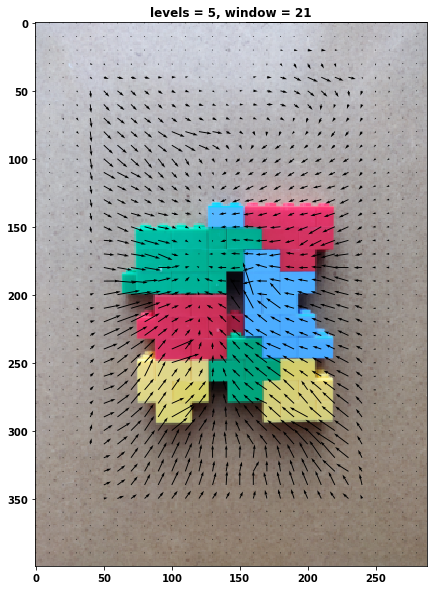

In [88]:
plot_pair(1,2)
plot_pair(1,3)
plot_pair(1,4)

#### Your Comments on the results of Part 4:

For pair of im1 and im2, it is obvious that objece move left and upward. The optical flow shows the same trend.

For pair of im1 and im3, oject move down and shif clockwise from visual observation. The optical flow indicates the same trend.

For pair of im1 and im4, the depth changed. The object is far from the camera, so we expect optical flow points to the center. The result meets our expectation. 

## Problem 2: Machine Learning [12 pts]

In this problem, you will implement several machine learning solutions for computer vision problems.

### Part 1: Initial setup [1 pts]

Follow the directions on https://pytorch.org/get-started/locally/ to install Pytorch on your computer. 

Note: You will not need GPU support for this assignment so don't worry if you don't have one. Furthermore, installing with GPU support is often more difficult to configure so it is suggested that you install the CPU only version. TA's will not provide any support related to GPU or CUDA.

Run the torch import statements below to verify your instalation.

Download the MNIST data from http://yann.lecun.com/exdb/mnist/.

Download the 4 zipped files, extract them into one folder, and change the variable 'path' in the code below. (Code taken from https://gist.github.com/akesling/5358964 )

Plot one random example image corresponding to each label from training data.

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

x = torch.rand(5, 3)
print(x)

tensor([[0.2590, 0.1011, 0.9034],
        [0.4636, 0.8731, 0.7522],
        [0.3322, 0.8268, 0.8460],
        [0.2619, 0.7306, 0.0518],
        [0.0565, 0.8047, 0.3827]])


In [3]:
import os
import struct

# Change path as required
path = "mnist/"

def read(dataset = "training", datatype='images'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    
    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)
        
trainData=np.array(list(read('training','images')))
trainLabels=np.array(list(read('training','labels')))
testData=np.array(list(read('testing','images')))
testLabels=np.array(list(read('testing','labels')))

In [9]:
# Understand the shapes of the each variable carying data
print(trainData.shape, trainLabels.shape)
print(testData.shape, testLabels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


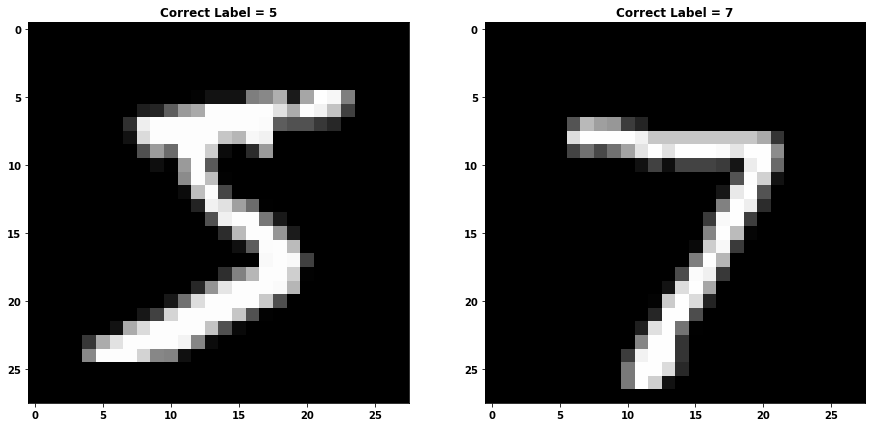

In [10]:
# display one image from each label
# """ ==========
# YOUR CODE HERE
# ========== """
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(trainData[0],cmap='gray')
plt.title('Correct Label = {}'.format(trainLabels[0]))
plt.subplot(1,2,2)
plt.imshow(testData[0],cmap='gray')
plt.title('Correct Label = {}'.format(testLabels[0]))
plt.show()

Some helper functions are given below.

In [4]:
# a generator for batches of data
# yields data (batchsize, 28, 28) and labels (batchsize)
# if shuffle, it will load batches in a random order
def DataBatch(data, label, batchsize, shuffle=True):
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

# tests the accuracy of a classifier
def test(testData, testLabels, classifier):
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize,shuffle=False):
        prediction = classifier(data)
        correct += np.sum(prediction==label)
    return correct/testData.shape[0]*100

# a sample classifier
# given an input it outputs a random class
class RandomClassifier():
    def __init__(self, classes=10):
        self.classes=classes
    def __call__(self, x):
        return np.random.randint(self.classes, size=x.shape[0])

randomClassifier = RandomClassifier()
print('Random classifier accuracy: %f' % 
      test(testData, testLabels, randomClassifier))

Random classifier accuracy: 10.010000


### Part 2: Confusion Matrix [2 pts]
Here you will implement a function that computes the confusion matrix for a classifier.
The matrix (M) should be nxn where n is the number of classes.
Entry M[i,j] should contain the fraction of images of class i that was classified as class j.
Can you justify the accuracy given by the random classifier?

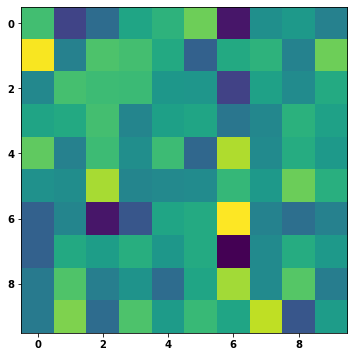

[[0.34 0.26 0.28 0.32 0.33 0.35 0.23 0.31 0.31 0.3 ]
 [0.39 0.3  0.34 0.34 0.32 0.28 0.32 0.33 0.3  0.35]
 [0.3  0.34 0.34 0.34 0.31 0.31 0.26 0.32 0.3  0.33]
 [0.32 0.32 0.34 0.3  0.32 0.32 0.29 0.3  0.33 0.32]
 [0.35 0.3  0.34 0.31 0.34 0.28 0.37 0.3  0.33 0.31]
 [0.31 0.31 0.37 0.3  0.3  0.3  0.33 0.31 0.35 0.33]
 [0.28 0.3  0.23 0.27 0.32 0.33 0.39 0.3  0.28 0.3 ]
 [0.28 0.32 0.32 0.33 0.31 0.33 0.22 0.3  0.33 0.31]
 [0.29 0.34 0.3  0.31 0.28 0.32 0.37 0.3  0.35 0.29]
 [0.29 0.36 0.28 0.34 0.32 0.34 0.32 0.37 0.27 0.32]]


In [8]:
# Using the tqdm module to visualize run time is suggested
# from tqdm import tqdm

# It would be a good idea to return the accuracy, along with the confusion 
# matrix, since both can be calculated in one iteration over test data, to 
# save time
def Confusion(testData, testLabels, classifier):
    M = np.zeros((10,10))
    acc = 0.0
    batchsize = 50
    for data,label in DataBatch(testData,testLabels,batchsize,shuffle=False):
        prediction = classifier(data)
        for i in range(10):
            for j in range(10):
                for k in range(batchsize):
                    M[prediction[k],label[k]] += 1
        acc += np.sum(prediction==label)
    M = M/np.linalg.norm(M,axis=0)
    acc = acc/testData.shape[0]*100
    return M, acc

def VisualizeConfusion(M):
    plt.figure(figsize=(14, 6))
    plt.imshow(M)
    plt.show()
    print(np.round(M,2))

M,_ = Confusion(testData, testLabels, randomClassifier)
VisualizeConfusion(M)

#### Your Comments on the accuracy & confusion matrix of random classifier:

It is hard to use a random classifier to find correct label, which leads to a 10% accuracy. The confusion matrix also shows that only few predection matches to label.

### Part 3: K-Nearest Neighbors (KNN) [4 pts]

* Here you will implement a simple knn classifier. The distance metric is Euclidean in pixel space. k refers to the number of neighbors involved in voting on the class, and should be 3. You are allowed to use sklearn.neighbors.KNeighborsClassifier.
* Display confusion matrix and accuracy for your KNN classifier trained on the entire train set. (should be ~97 %)
* After evaluating the classifier on the testset, based on the confusion matrix, mention the number that the number '7' is most often predicted to be, other than '7'.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
class KNNClassifer():
    def __init__(self, k=3):
        # k is the number of neighbors involved in voting
        self.k = k
        
    def train(self, trainData, trainLabels):
        train = trainData.reshape(trainData.shape[0],-1)
        self.clf = KNeighborsClassifier(self.k,weights='uniform')
        self.clf.fit(train, trainLabels)
        
    def __call__(self, x):
        # this method should take a batch of images
        # and return a batch of predictions
        test = x.reshape(x.shape[0],-1)
        self.y = self.clf.predict(test)
        return self.y


# test your classifier with only the first 100 training examples (use this
# while debugging)
# note you should get ~ 65 % accuracy
knnClassiferX = KNNClassifer()
knnClassiferX.train(trainData[:100], trainLabels[:100])
print ('KNN classifier accuracy: %f'%test(testData, testLabels, knnClassiferX))

KNN classifier accuracy: 64.760000


In [6]:
# test your classifier with all the training examples (This may take a while)
knnClassifer = KNNClassifer()
knnClassifer.train(trainData, trainLabels)

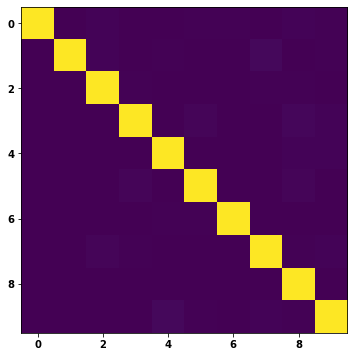

[[1.   0.   0.01 0.   0.   0.01 0.01 0.   0.01 0.  ]
 [0.   1.   0.01 0.   0.01 0.   0.   0.02 0.   0.01]
 [0.   0.   1.   0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   1.   0.   0.01 0.   0.   0.02 0.01]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.01 0.01]
 [0.   0.   0.   0.01 0.   1.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.01 1.   0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.   0.   1.   0.   0.01]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.02 0.   0.   0.01 0.   1.  ]]
KNN classifier accuracy: 97.050000


In [9]:
# display confusion matrix for your KNN classifier with all the training examples
# (This may take a while)
M_knn,acc_knn = Confusion(testData, testLabels, knnClassifer)
VisualizeConfusion(M_knn)
print ('KNN classifier accuracy: %f'%acc_knn)

#### Answer

The accuracy for the KNN classifier is around 97%, which is high. Thus, it is expected that confusion matrix should have all ones on the diagonal elements. The plot of confusion matrix matches our expectation. It also can be seen that few numbers are easy to be labeled as other numbers, like '7' and '8'.

### Part 4: Principal Component Analysis (PCA) K-Nearest Neighbors (KNN) [5 pts]
Here you will implement a simple KNN classifer in PCA space (for k=3 and 25 principal components).
You should implement PCA yourself using svd (you may not use sklearn.decomposition.PCA
or any other package that directly implements PCA transformations

Is the testing time for PCA KNN classifier more or less than that for KNN classifier? Comment on why it differs if it does.

In [10]:
class PCAKNNClassifer():
    def __init__(self, components=25, k=3):
        # components = number of principal components
        # k is the number of neighbors involved in voting
        self.components = components
        self.k = k
        
    def train(self, trainData, trainLabels):
        train = trainData.reshape(trainData.shape[0],-1)
        cov = np.cov(train.T)
        U, S, V = np.linalg.svd(cov)
        self.proj_pca = V[:self.components+1].T   
        train_pca = train@self.proj_pca
        self.clf = KNeighborsClassifier(self.k,weights='uniform')
        self.clf.fit(train_pca,trainLabels)
        
    def __call__(self, x):
        # this method should take a batch of images
        # and return a batch of predictions
        test = x.reshape(x.shape[0],-1)
        test_pca = test@self.proj_pca
        self.y = self.clf.predict(test_pca)
        return self.y


# test your classifier with only the first 100 training examples (use this
# while debugging)
pcaknnClassiferX = PCAKNNClassifer()
pcaknnClassiferX.train(trainData[:100], trainLabels[:100])
print ('PCA-KNN classifier accuracy: %f'%test(testData, testLabels, pcaknnClassiferX))

PCA-KNN classifier accuracy: 65.940000


In [11]:
# test your classifier with all the training examples
pcaknnClassifer = PCAKNNClassifer()
pcaknnClassifer.train(trainData, trainLabels)

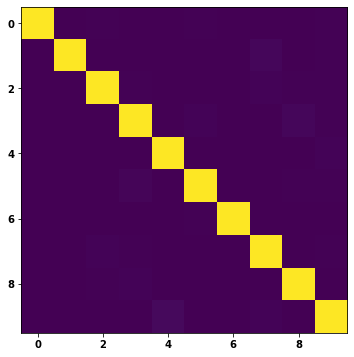

[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.02 0.   0.01]
 [0.   0.   1.   0.01 0.   0.   0.   0.01 0.01 0.  ]
 [0.   0.   0.   1.   0.   0.01 0.   0.   0.02 0.01]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.01]
 [0.   0.   0.   0.02 0.   1.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.01 1.   0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.   0.   1.   0.   0.01]
 [0.   0.   0.   0.01 0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.03 0.   0.   0.01 0.   1.  ]]
PCA-KNN classifier accuracy: 97.400000


In [12]:
# display confusion matrix for your PCA KNN classifier with all the training examples
M_pca,acc_pca = Confusion(testData, testLabels, pcaknnClassifer)
VisualizeConfusion(M_pca)
print ('PCA-KNN classifier accuracy: %f'%acc_pca)

#### Comments:

The pca-knn method spends less time on the test data, where the accuracy is still on the same level around 97%. The reason is that PCA method reduces the dimensionality of data set significantly

## Problem 3: Deep learning [14 pts]
Below is some helper code to train your deep networks.

### Part 1:  Training with PyTorch [2 pts]
Below is some helper code to train your deep networks. 
Complete the train function for DNN below. You should write down the training operations in this function. That means, for a batch of data you have to initialize the gradients, forward propagate the data, compute error, do back propagation and finally update the parameters. This function will be used in the following questions with different networks.
You can look at https://pytorch.org/tutorials/beginner/pytorch_with_examples.html for reference.

In [19]:
# base class for your deep neural networks. It implements the training loop (train_net).
# You will need to implement the "__init__()" function to define the networks
# structures and "forward()", to propagate your data, in the following problems.

import torch.nn.init
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from tqdm import tqdm
from scipy.stats import truncnorm

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        pass
    
    def forward(self, x):
        raise NotImplementedError
    
    def train_net(self, trainData, trainLabels, epochs=1, batchSize=50):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr = 3e-4)
        
        for epoch in range(epochs):
            self.train()  # set netowrk in training mode
            for i, (data,labels) in enumerate(DataBatch(trainData, trainLabels, batchSize, shuffle=True)):
                data = Variable(torch.FloatTensor(data))
                labels = Variable(torch.LongTensor(labels))
                
                # YOUR CODE HERE------------------------------------------------
                # Train the model using the optimizer and the batch data
                optimizer.zero_grad()
                outputs = self.forward(data)
                loss = criterion(outputs,labels)
                loss.backward()
                optimizer.step()
                #------------------------------------------------------------------
                #-----End of your code, don't change anything else here------------
                
            self.eval()  # set network in evaluation mode
            print ('Epoch:%d Accuracy: %f'%(epoch+1, test(testData, testLabels, self))) 
    
    def __call__(self, x):
        inputs = Variable(torch.FloatTensor(x))
        prediction = self.forward(inputs)
        return np.argmax(prediction.data.cpu().numpy(), 1)

# helper function to get weight variable
def weight_variable(shape):
    initial = torch.Tensor(truncnorm.rvs(-1/0.01, 1/0.01, scale=0.01, size=shape))
    return Parameter(initial, requires_grad=True)

# helper function to get bias variable
def bias_variable(shape):
    initial = torch.Tensor(np.ones(shape)*0.1)
    return Parameter(initial, requires_grad=True)

In [20]:
# example linear classifier - input connected to output
# you can take this as an example to learn how to extend DNN class
class LinearClassifier(DNN):
    def __init__(self, in_features=28*28, classes=10):
        super(LinearClassifier, self).__init__()
        # in_features=28*28
        self.weight1 = weight_variable((classes, in_features))
        self.bias1 = bias_variable((classes))
    
    def forward(self, x):
        # linear operation
        y_pred = torch.addmm(self.bias1, x.view(list(x.size())[0], -1), self.weight1.t())
        return y_pred
    
trainData=np.array(list(read('training','images')))
trainData=np.float32(np.expand_dims(trainData,-1))/255
trainData=trainData.transpose((0,3,1,2))
trainLabels=np.int32(np.array(list(read('training','labels'))))

testData=np.array(list(read('testing','images')))
testData=np.float32(np.expand_dims(testData,-1))/255
testData=testData.transpose((0,3,1,2))
testLabels=np.int32(np.array(list(read('testing','labels'))))

In [45]:
# test the example linear classifier (note you should get around 90% accuracy
# for 10 epochs and batchsize 50)
linearClassifier = LinearClassifier()
linearClassifier.train_net(trainData, trainLabels, epochs=10)

Epoch:1 Accuracy: 89.270000
Epoch:2 Accuracy: 90.730000
Epoch:3 Accuracy: 91.290000
Epoch:4 Accuracy: 91.620000
Epoch:5 Accuracy: 91.790000
Epoch:6 Accuracy: 92.140000
Epoch:7 Accuracy: 92.230000
Epoch:8 Accuracy: 92.270000
Epoch:9 Accuracy: 92.300000
Epoch:10 Accuracy: 92.370000


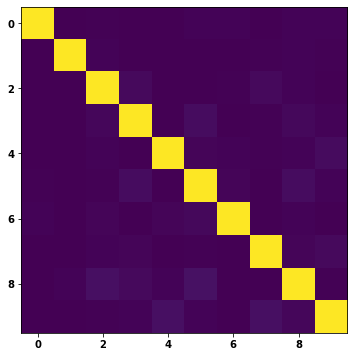

[[1.   0.   0.01 0.   0.   0.01 0.01 0.   0.01 0.01]
 [0.   1.   0.01 0.   0.   0.   0.   0.01 0.01 0.01]
 [0.   0.   1.   0.03 0.   0.   0.01 0.03 0.01 0.  ]
 [0.   0.   0.02 1.   0.   0.03 0.   0.01 0.02 0.01]
 [0.   0.   0.01 0.   1.   0.01 0.01 0.01 0.01 0.03]
 [0.01 0.   0.   0.03 0.   1.   0.01 0.   0.03 0.01]
 [0.01 0.   0.01 0.   0.01 0.02 1.   0.   0.01 0.  ]
 [0.   0.   0.01 0.01 0.   0.01 0.   1.   0.01 0.03]
 [0.   0.01 0.04 0.02 0.01 0.04 0.   0.   1.   0.01]
 [0.   0.   0.01 0.01 0.04 0.01 0.   0.04 0.02 1.  ]]


In [46]:
# display confusion matrix
M_liner,_ = Confusion(testData, testLabels, linearClassifier)
VisualizeConfusion(M_liner)

### Part 2: Single Layer Perceptron [2 pts]
The simple linear classifier implemented in the cell already performs quite well. Plot the filter weights corresponding to each output class (weights, not biases) as images. (Normalize weights to lie between 0 and 1 and use color maps like 'inferno' or 'plasma' for good results). Comment on what the weights look like and why that may be so.


In [89]:
# Plot filter weights corresponding to each class, you may have to reshape them to make sense out of them
# linearClassifier.weight1.data will give you the first layer weights
def plot_weight(weight,factor):
    plt.figure(figsize=(15,15))
    for i in range(10):
        im = weight[i,:].reshape(factor,factor).numpy()
        im -= np.min(im)
        im /= np.max(im)
        plt.subplot(1,10,i+1)
        plt.imshow(im,cmap='inferno')
        plt.title(i)
        plt.axis('off')
    plt.show()

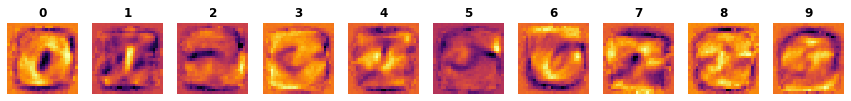

In [90]:
plot_weight(linearClassifier.weight1.data,28)

#### Comments on weights

The weights shows the shape of digit number, which means it is learning the digit as it goes forward and backpropagate.

### Part 3: Multi Layer Perceptron (MLP) [5 pts]
Here you will implement an MLP. The MLP should consist of 2 layers (matrix multiplication and bias offset) that map to the following feature dimensions:

* 28x28 -> hidden (100)
* hidden -> classes

* The hidden layer should be followed with a ReLU nonlinearity. The final layer should not have a nonlinearity applied as we desire the raw logits output.
* The final output of the computation graph should be stored in self.y as that will be used in the training.

Display the confusion matrix and accuracy after training. Note: You should get ~ 97 % accuracy for 10 epochs and batch size 50.

Plot the filter weights corresponding to the mapping from the inputs to the first 10 hidden layer outputs (out of 100). Do the weights look similar to the weights plotted in the previous problem? Why or why not?

In [48]:
class MLPClassifer(DNN):
    def __init__(self, in_features=28*28, classes=10, hidden=100):
        super (MLPClassifer, self ).__init__()
        self.weight1 = weight_variable((hidden, in_features))
        self.bias1 = bias_variable((hidden))
        self.weight2 = weight_variable((classes, hidden))
        self.bias2 = bias_variable((classes))
    
    def forward(self, x):
        h1 = F.relu(torch.addmm(self.bias1, x.view(list(x.size())[0], -1), self.weight1.t()))
        y_pred = torch.addmm(self.bias2, h1, self.weight2.t())
        return y_pred

mlpClassifer = MLPClassifer()
mlpClassifer.train_net(trainData, trainLabels, epochs=10, batchSize=50)

Epoch:1 Accuracy: 91.370000
Epoch:2 Accuracy: 93.040000
Epoch:3 Accuracy: 94.180000
Epoch:4 Accuracy: 94.670000
Epoch:5 Accuracy: 95.470000
Epoch:6 Accuracy: 95.920000
Epoch:7 Accuracy: 96.320000
Epoch:8 Accuracy: 96.540000
Epoch:9 Accuracy: 96.700000
Epoch:10 Accuracy: 96.620000


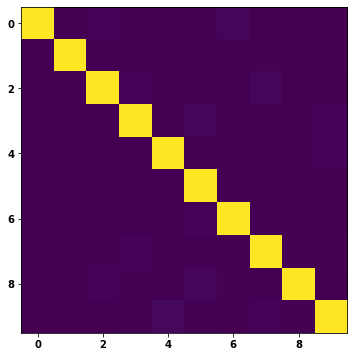

[[1.   0.   0.01 0.   0.   0.01 0.01 0.   0.01 0.01]
 [0.   1.   0.   0.   0.   0.   0.   0.01 0.   0.01]
 [0.   0.   1.   0.01 0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.01 1.   0.   0.01 0.   0.   0.01 0.01]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.01 0.01]
 [0.   0.   0.   0.01 0.   1.   0.01 0.   0.01 0.  ]
 [0.   0.   0.01 0.   0.01 0.01 1.   0.   0.01 0.  ]
 [0.   0.   0.01 0.01 0.   0.   0.   1.   0.01 0.01]
 [0.   0.01 0.01 0.01 0.   0.01 0.01 0.   1.   0.  ]
 [0.   0.   0.   0.01 0.02 0.   0.   0.01 0.01 1.  ]]


In [49]:
# Plot confusion matrix
M_mlp,_ = Confusion(testData, testLabels, mlpClassifer)
VisualizeConfusion(M_mlp)

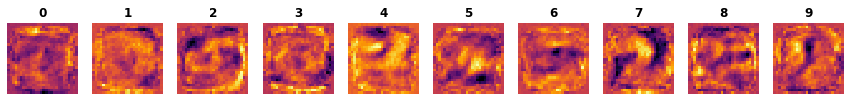

In [50]:
# Plot filter weights
plot_weight(mlpClassifer.weight1.data,28)

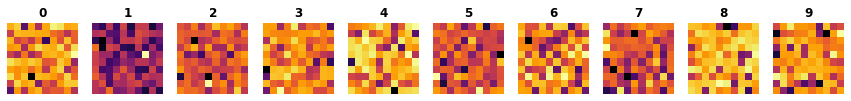

In [51]:
plot_weight(mlpClassifer.weight2.data,10)

#### Comments on weights:

In a sense, it is similar to the previous one that shows the digit shape.

### Part 3: Convolutional Neural Network (CNN) [5 pts]
Here you will implement a CNN with the following architecture:

* n=5
* ReLU( Conv(kernel_size=5x5, stride=2, output_features=n) )
* ReLU( Conv(kernel_size=5x5, stride=2, output_features=n*2) )
* ReLU( Linear(hidden units = 64) )
* Linear(output_features=classes)

So, 2 convolutional layers, followed by 1 fully connected hidden layer and then the output layer

Display the confusion matrix and accuracy after training. You should get around ~ 98 % accuracy for 10 epochs and batch size 50.<br><br>
**Note: You are not allowed to use torch.nn.Conv2d() and torch.nn.Linear(), Using these will lead to deduction of points. Use the declared conv2d(), weight_variable() and bias_variable() functions.** Although, in practice, when you move forward after this class you will use torch.nn.Conv2d() which makes life easier and hides all the operations underneath.

In [27]:
def conv2d(x, W, stride):
    # x: input
    # W: weights (out, in, kH, kW)
    return F.conv2d(x, W, stride=stride, padding=2)

# Defining a Convolutional Neural Network
class CNNClassifer(DNN):
    def __init__(self, classes=10, n=5):
        super(CNNClassifer, self).__init__()
        self.w1 = weight_variable((n,1,5,5))
        self.w2 = weight_variable((n*2,n,5,5))
        self.w3 = weight_variable((64,n*2*7*7))
        self.w4 = weight_variable((classes,64))
        self.b3 = bias_variable((64))
        self.b4 = bias_variable((classes))
        
    def forward(self, x):
        cov1 = F.relu(conv2d(x,self.w1,2))
        cov2 = F.relu(conv2d(cov1,self.w2,2))
        fc = F.relu(torch.addmm(self.b3,cov2.view(-1,self.num_flat_features(cov2)),self.w3.t()))
        ypred = torch.addmm(self.b4,fc,self.w4.t())
        return ypred
    
    # Determine the number of features in a batch of tensors
    def num_flat_features(self, x):
        size = x.size()[1:]
        return np.prod(size)
    
cnnClassifer = CNNClassifer()
cnnClassifer.train_net(trainData, trainLabels, epochs=10)

Epoch:1 Accuracy: 91.570000
Epoch:2 Accuracy: 94.340000
Epoch:3 Accuracy: 95.590000
Epoch:4 Accuracy: 96.190000
Epoch:5 Accuracy: 96.820000
Epoch:6 Accuracy: 97.190000
Epoch:7 Accuracy: 97.230000
Epoch:8 Accuracy: 97.540000
Epoch:9 Accuracy: 97.880000
Epoch:10 Accuracy: 98.020000


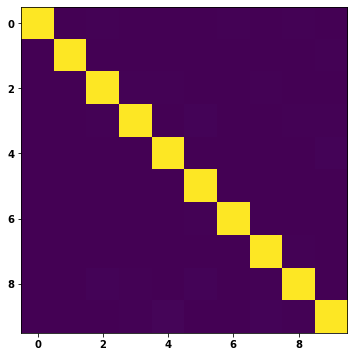

[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.01 0.01 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.01 0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.01]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.01 0.01 0.   0.01 0.   0.   1.   0.  ]
 [0.   0.   0.   0.01 0.01 0.   0.   0.01 0.   1.  ]]


In [44]:
# Plot Confusion matrix
M_cnn,_ = Confusion(testData, testLabels, cnnClassifer)
VisualizeConfusion(M_cnn)

* Note that the MLP/ConvNet approaches lead to an accuracy a little higher than the K-NN approach. 
* In general, Neural net approaches lead to significant increase in accuracy, but in this case since the problem is not too hard, the increase in accuracy is not very high.
* However, this is still quite significant considering the fact that the ConvNets we've used are relatively simple while the accuracy achieved using K-NN is with a search over 60,000 training images for every test image.
* You can look at the performance of various machine learning methods on this problem at http://yann.lecun.com/exdb/mnist/
* You can learn more about neural nets/ pytorch at<br> https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
* You can play with a demo of neural network created by Daniel Smilkov and Shan Carter at https://playground.tensorflow.org/